# Comparison of results and choice of hyper_params. 

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from tensorflow.keras.models import model_from_json
from return_stats import *
from create_plots import *
from dmd_functions import *
from tensorflow import keras
import pickle
import numpy as np
from pydmd import DMD
from numpy import matlib

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

# Step 1: Read in a random test batch. 

In [16]:
random_batch = pickle.load(open('./data/dataset_pendulum_random_batch.pkl', 'rb'))
random_batch = random_batch.numpy()

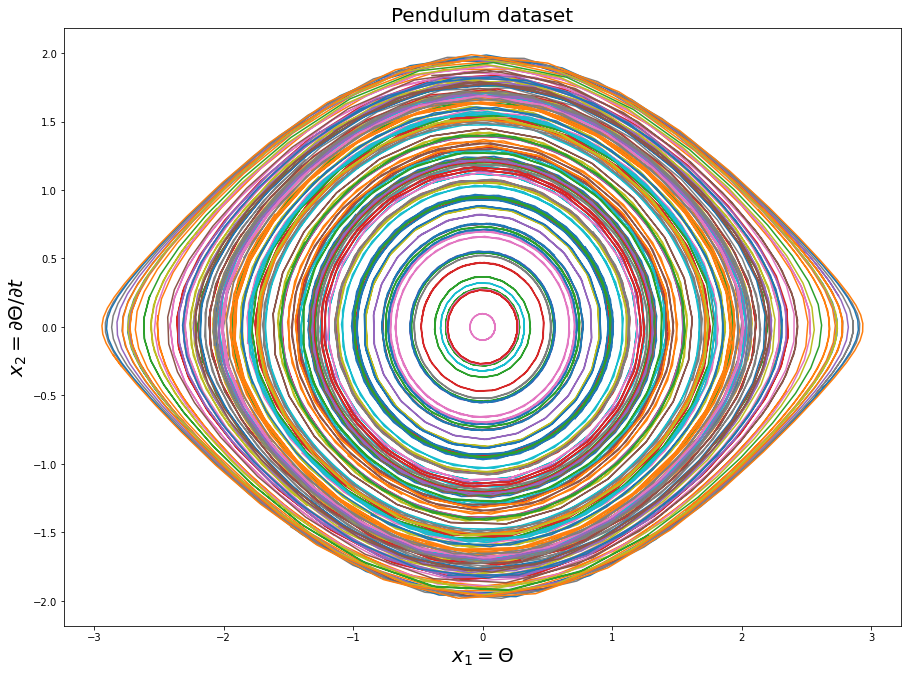

In [17]:
_ = plt.figure(figsize=(15,11))
for ii in np.arange(0, 256, 2):
    plt.plot(random_batch[ii, 0, :], random_batch[ii, 1, :])
plt.xlabel("$x_{1} = \Theta $", fontsize=20)
plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.title("Pendulum dataset", fontsize=20)
plt.show()


# Step 2: Analyze DMD. 

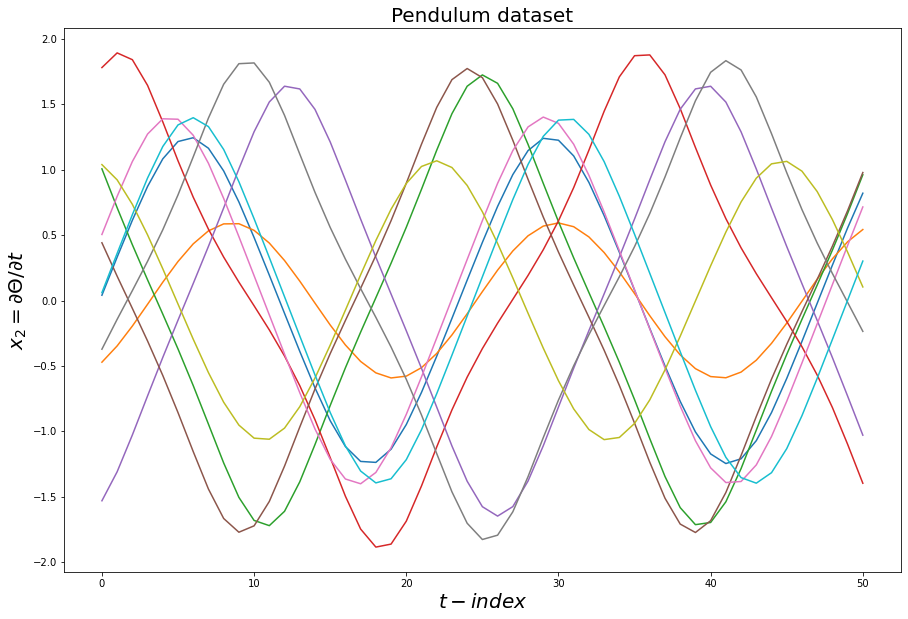

In [18]:
_ = plt.figure(figsize=(15, 10))
for ii in range(0, 10):
    plt.plot(np.arange(len(random_batch[ii, 1, :])), random_batch[ii, 1, :])


plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.xlabel("$ t -index$", fontsize=20)
plt.title("Pendulum dataset", fontsize=20)

plt.show()

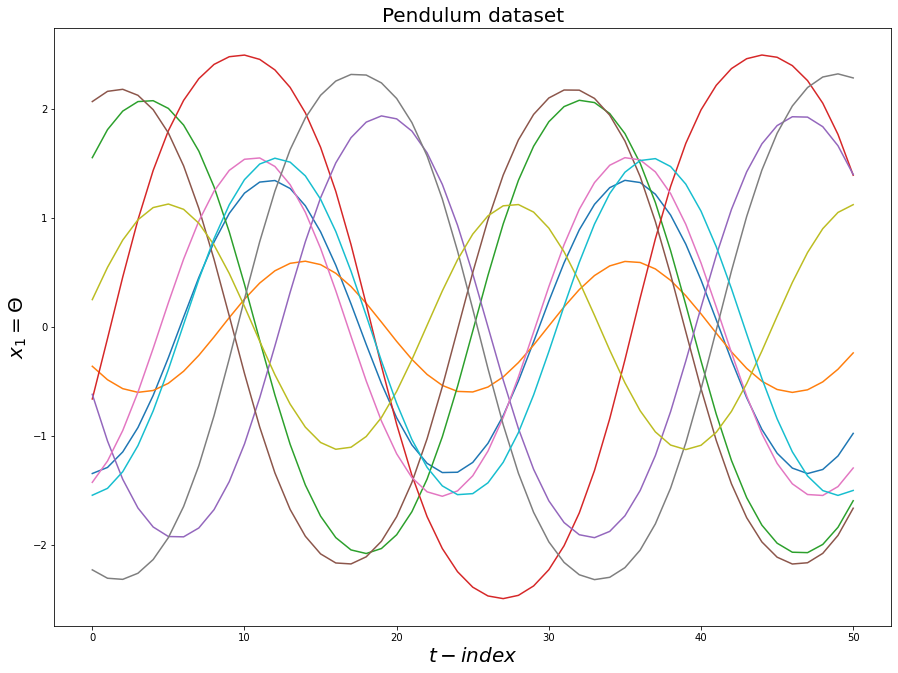

In [19]:
_ = plt.figure(figsize=(15, 11))
for ii in range(0, 10):
    plt.plot(np.arange(len(random_batch[ii, 0, :])), random_batch[ii, 0, :])


plt.ylabel("$x_{1}= \Theta $", fontsize=20)
plt.xlabel("$ t -index$", fontsize=20)
plt.title("Pendulum dataset", fontsize=20)

plt.show()

# DMD fit without windowing. 

In [20]:
def dmd_fit(x_mat):
    # Perform DMD method
    x_minus = x_mat[:, :-1]
    x_plus = x_mat[:, 1:]

    # singular value decomposition.
    u, s, vh = np.linalg.svd(x_minus, full_matrices=False)
    u, vh = np.matrix(u), np.matrix(vh)

    # compute Atilde.
    Atilde = u.H @ x_plus @ vh.H @ np.diag(1. / s)

    # compute the eigenvalues and eigenvectors of Atilde.
    eigs, eig_vecs = np.linalg.eig(Atilde)

    # find b.
    b = np.linalg.solve(eig_vecs, x_mat[:, 0])

    # reconstruct dmd.
    dmd_rec = np.zeros((x_mat.shape[0], x_mat.shape[1]), dtype = "complex_")
    
    dmd_rec[:, 0] = x_mat[:, 0]
    
    power_lam = np.diag(np.ones(len(eigs)))
                        
    for ii in range(1, x_mat.shape[1]):
        power_lam = power_lam @ np.diag(eigs)
        dmd_rec[:, ii] = eig_vecs @ power_lam @ b
        #dmd_rec[:, ii] = (Atilde**ii) @ x_mat[:, 0]
    return [eigs, eig_vecs, b, dmd_rec]

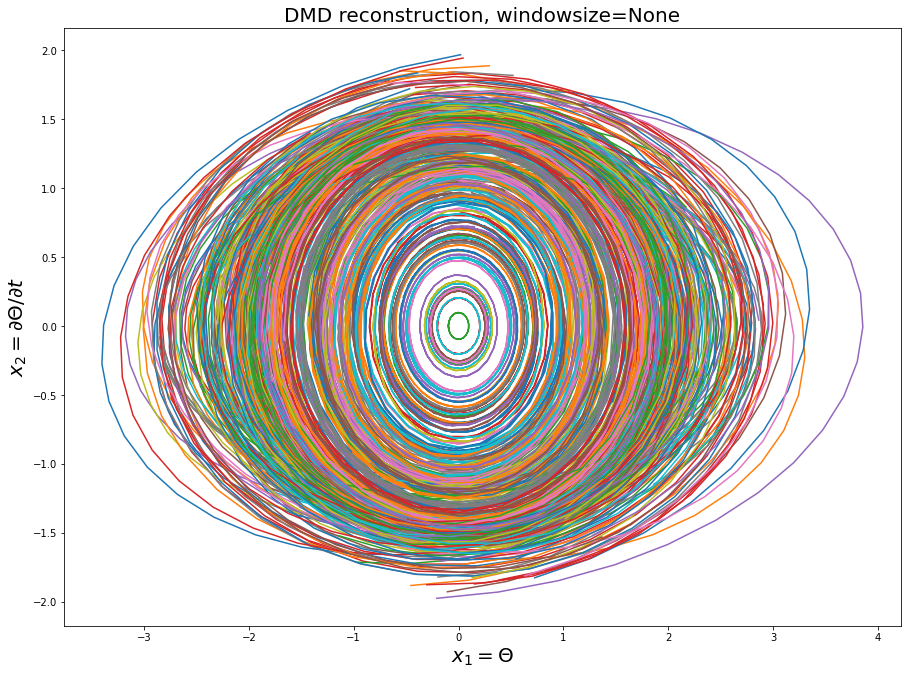

In [21]:
_ = plt.figure(figsize=(15,11))
dmd_rec_mat = np.zeros((random_batch.shape[0], random_batch.shape[1], random_batch.shape[2]))
for ii in np.arange(0, 256):
    eigs, eig_vecs, b, dmd_rec = dmd_fit(random_batch[ii])
    dmd_rec_mat[ii] = dmd_rec.real.astype(np.float32)
    plt.plot(dmd_rec.real[0, :], dmd_rec.real[1, :])
plt.xlabel("$x_{1} = \Theta $", fontsize=20)
plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.title("DMD reconstruction, windowsize=None", fontsize=20)
plt.show()

In [22]:
print("Prediction loss = ", ((dmd_rec_mat - random_batch)**2).mean())

Prediction loss =  2.619497330508236


In [23]:
windowing_size = 50 # AKA 50 pairs. 

In [24]:
reshape_batch = np.zeros((int(random_batch.shape[0]/windowing_size), int(windowing_size*random_batch.shape[1]), random_batch.shape[2]))
reshape_batch_rec = np.zeros((int(random_batch.shape[0]/windowing_size), int(windowing_size*random_batch.shape[1]), random_batch.shape[2]))
kk = 0
for jj in range(0, int(random_batch.shape[0]/windowing_size)):
    for ii in range(windowing_size):
        reshape_batch[jj, 2*ii :] = random_batch[kk, 0, :]
        reshape_batch[jj, 2*ii + 1, :] = random_batch[kk, 1, :]
        kk += 1

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\pydmd\dmdbase.py:215: UserWarning: Input data matrix X has condition number 98509387.19636291. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))
C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\pydmd\dmdbase.py:215: UserWarning: Input data matrix X has condition number 71382448.45675522. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))
C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\pydmd\dmdbase.py:215: UserWarning: Input data matrix X has condition number 294689205.7803376. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))
C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\pydmd\dmdbase.py:215: UserWarning: Input data matrix X has condition numb

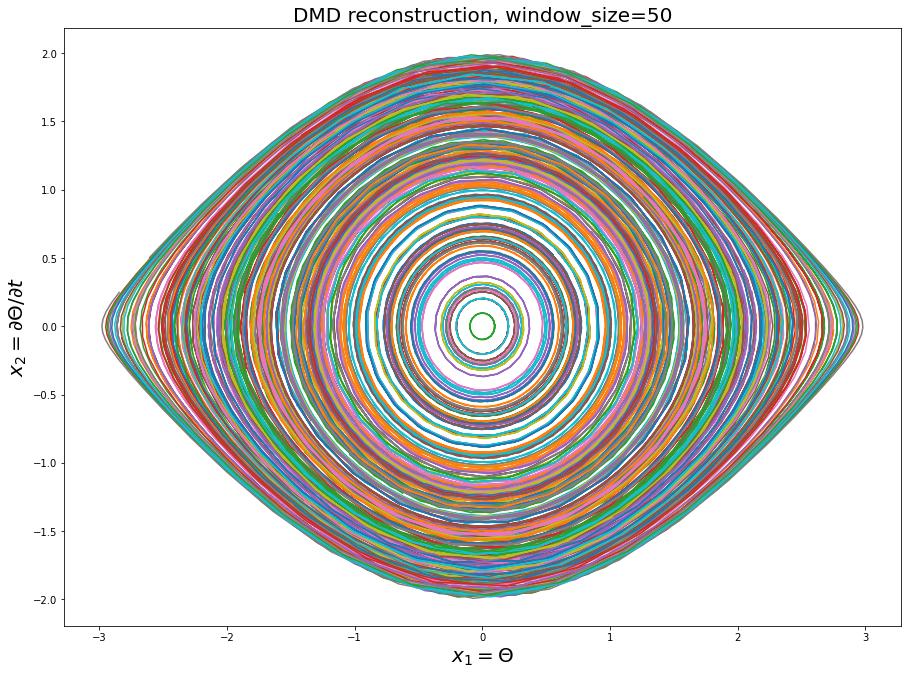

In [25]:
_ = plt.figure(figsize=(15,11))

for jj in range(reshape_batch.shape[0]):
    reshape_batch.shape
    dmd = DMD(svd_rank=50)
    dmd.fit(reshape_batch[jj])
    dmd_rec = dmd.reconstructed_data
    reshape_batch_rec[jj] = dmd_rec.real
    for ii in range(windowing_size):
        plt.plot(dmd_rec.real[2*ii, :], dmd_rec.real[2*ii + 1, :])
plt.xlabel("$x_{1} = \Theta $", fontsize=20)
plt.ylabel("$x_{2}= \partial \Theta /\partial t $", fontsize=20)
plt.title("DMD reconstruction, window_size=50", fontsize=20)
plt.show()

In [26]:
print("Prediction loss = ", ((reshape_batch - reshape_batch_rec)**2).mean())

Prediction loss =  6.817233212876372e-10


# Step 3: Load a saved model. 

In [27]:
hyp_params = dict()
hyp_params['num_t_steps'] = 51
hyp_params['phys_dim'] = 2
hyp_params['num_init_conds'] = 1000
hyp_params['batch_size'] = 256 # MAJOR PARAMETER CHOICE
hyp_params['num_epochs'] = 500  # MAJOR PARAMETER CHOICE
hyp_params['window_size'] = None # MAJOR PARAMETER CHOICE

# Encoding/Decoding Layer Parameters
hyp_params['num_en_layers'] = 2 # MAJOR PARAMETER CHOICE
hyp_params['num_en_neurons'] = 80  # MAJOR PARAMETER CHOICE
hyp_params['latent_dim'] = 2

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'
hyp_params['regfac'] = 3e-3

hyp_params['c1'] = 1 # coefficient autoencoder loss.
hyp_params['c2'] = 1 # coefficient of dmd loss. 
hyp_params['c3'] = 1 # coefficient of pred loss. 


myMachine = DMDMachine(hyp_params)

print("DMD Loss on input dataset = ", (myMachine.get_linearity_loss(tf.convert_to_tensor(random_batch)).numpy()))

y_pred = DMDMachine.compute_pred_batch_mat(myMachine, y_data_mat=tf.convert_to_tensor(random_batch))
# y_pred_reshape =  DMDMachine.compute_predict_batch_reshape(myMachine, y_data_mat=tf.convert_to_tensor(random_batch))

print("Pred Loss on input dataset = ", (myMachine.pred_loss(tf.convert_to_tensor(random_batch), y_pred)).numpy())

# print("Pred Loss windowing on input dataset = ", (myMachine.pred_loss(tf.convert_to_tensor(random_batch), y_pred_reshape)).numpy())


DMD Loss on input dataset =  0.15743455
Pred Loss on input dataset =  0.026583638


In [37]:
myMachine.autoencoder = keras.models.load_model("./models/my_model_Ex2_oct2", compile=False)

In [38]:
test_run = myMachine(random_batch)

# Step 3: Plot results.

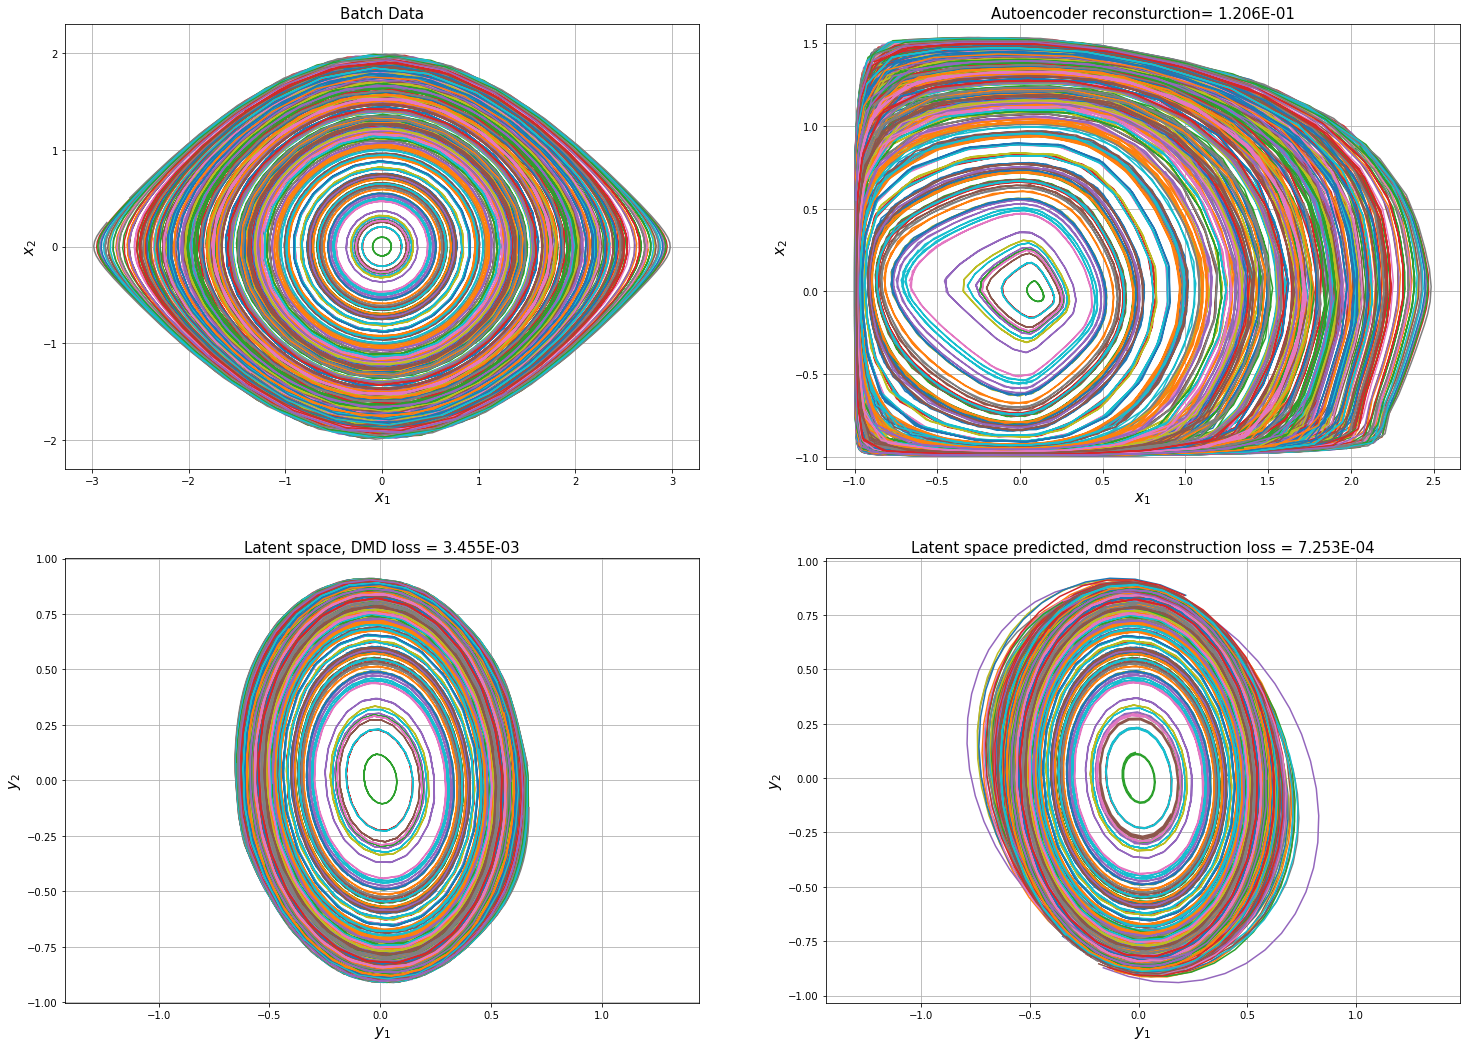

In [40]:
new_plot_model(test_run, random_batch)

# Step 4: Repeat for all models saved. 

In [45]:
myMachine.autoencoder = keras.models.load_model("./models/my_model_Ex2_oct21", compile=False)
test_run = myMachine(random_batch)

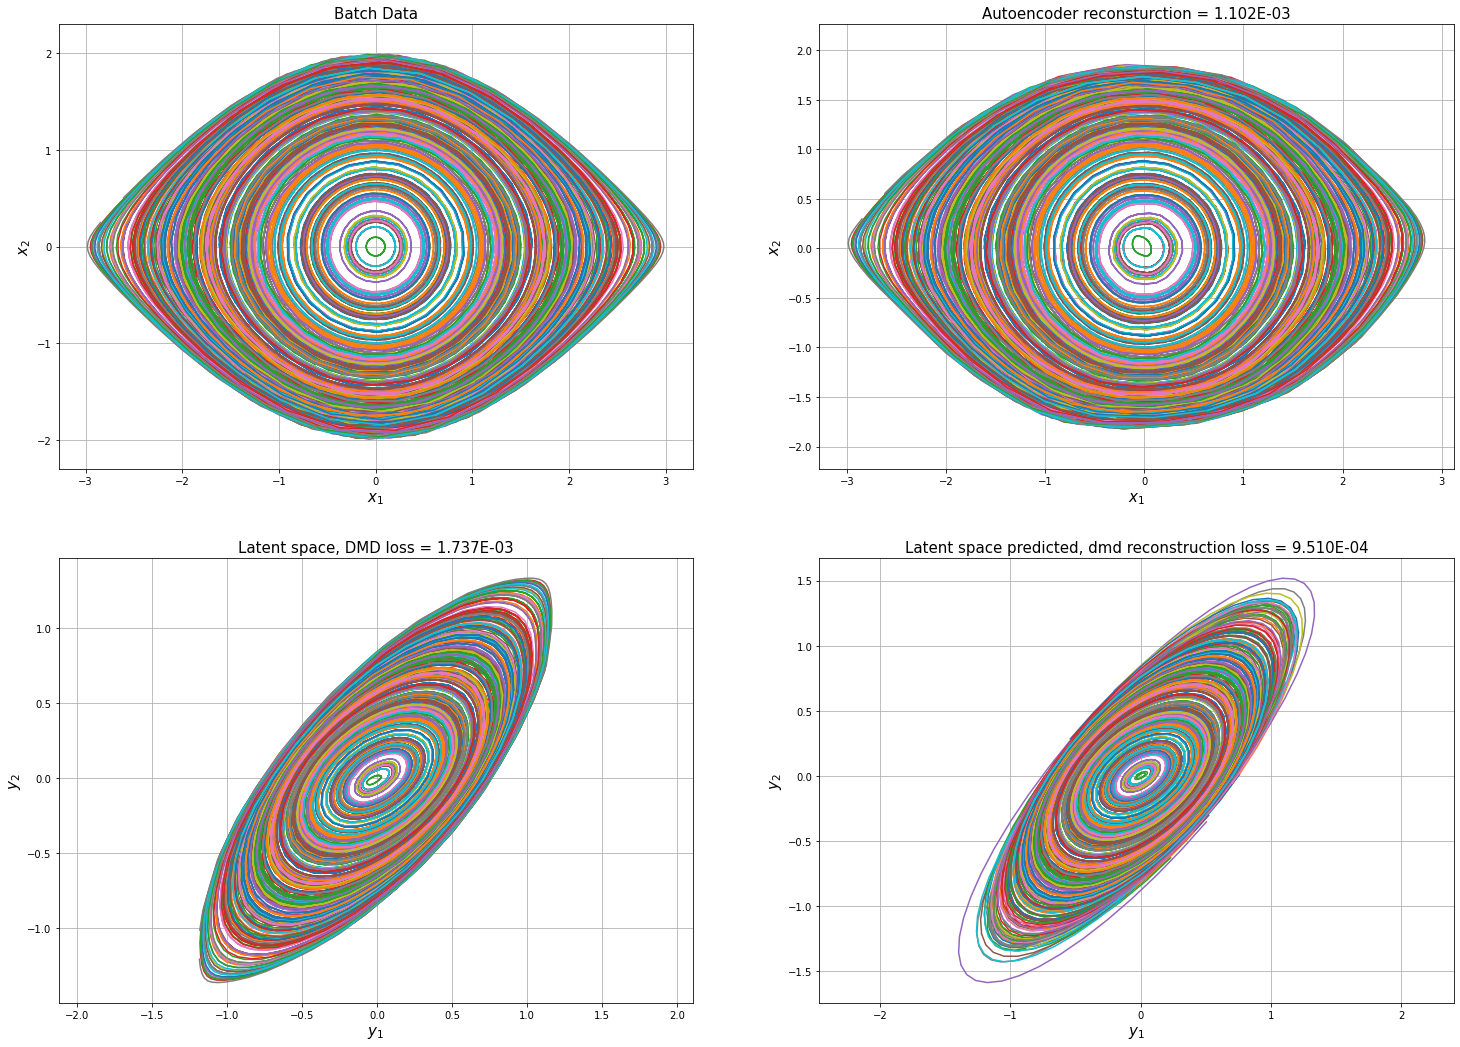

In [46]:
new_plot_model(test_run, random_batch)

In [43]:
print("DMD loss = ", format(test_run[2].numpy(), ".3E"))
print("predict loss = ", format(test_run[5].numpy(), ".3E"))

DMD loss =  1.737E-03
predict loss =  9.510E-04


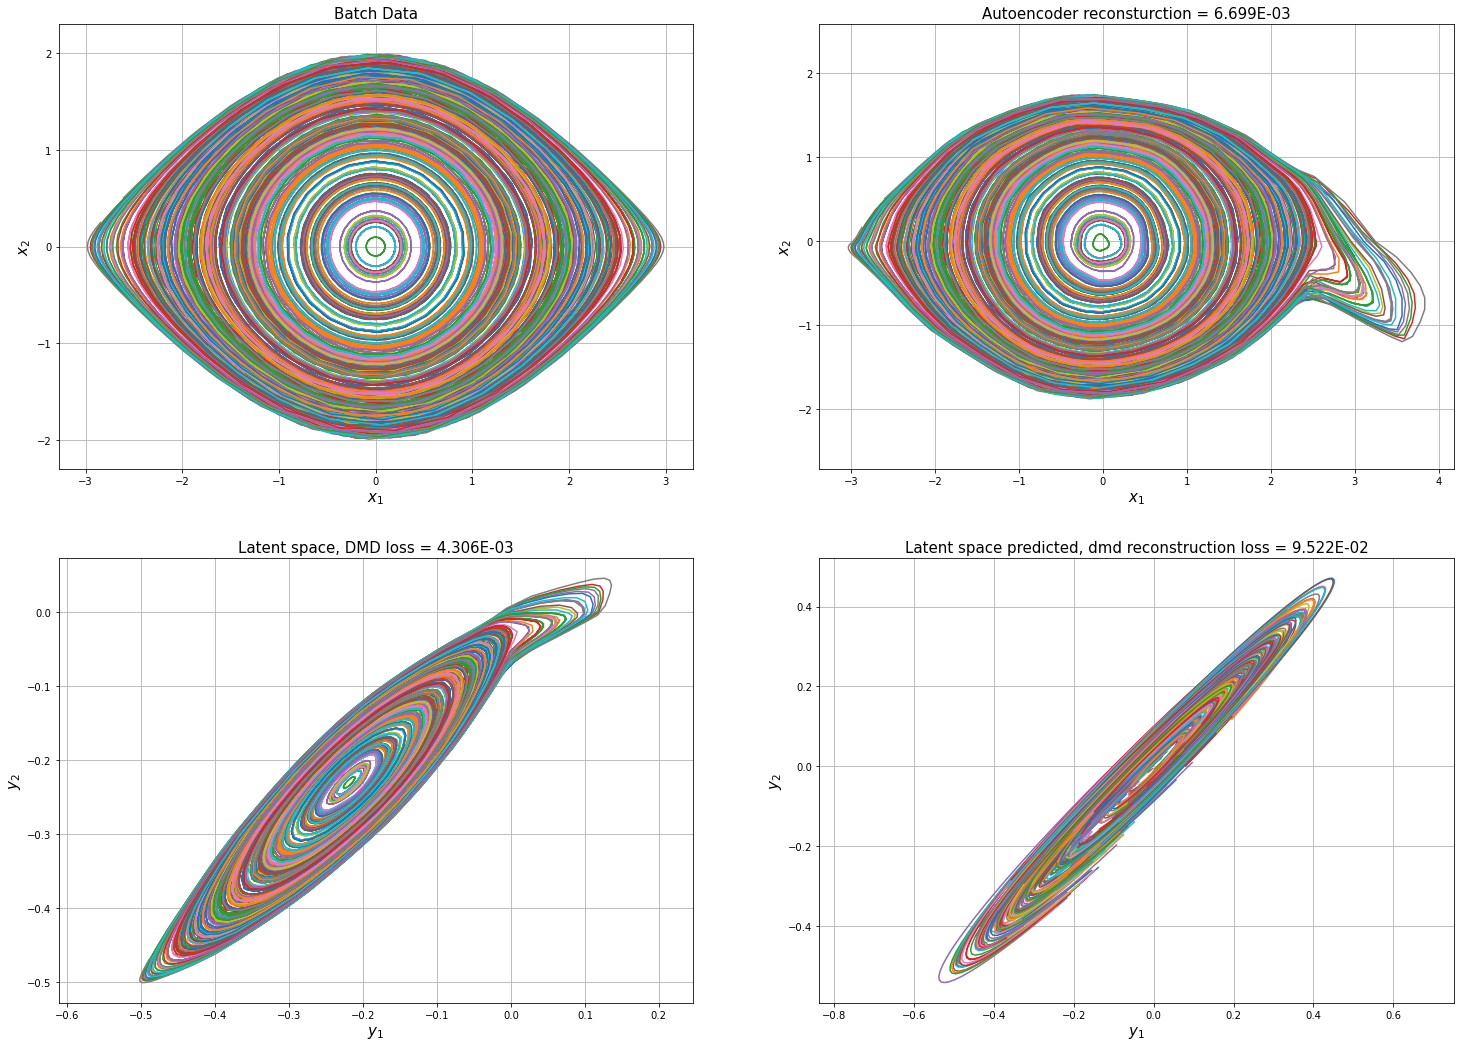

In [47]:
myMachine.autoencoder = keras.models.load_model("./models/my_model_Ex2_oct19", compile=False)
test_run = myMachine(random_batch)
new_plot_model(test_run, random_batch)

# Create figure #2 in DMD Autoencoder paper/report. 

In [48]:
myMachine.autoencoder = keras.models.load_model("./models/my_model_Ex2_oct21", compile=False)
test_run = myMachine(random_batch)

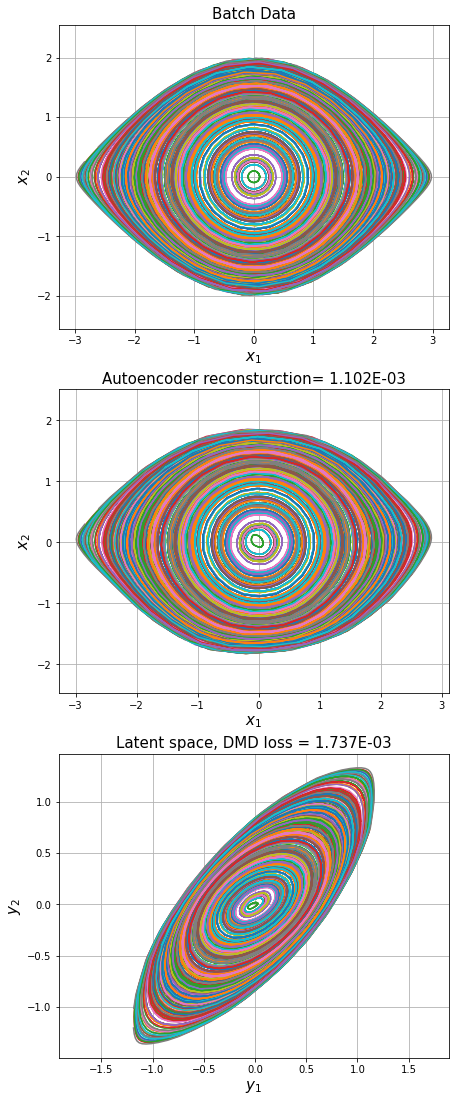

In [50]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7, 19))

rect = fig.patch
rect.set_facecolor("white")

observed_data = random_batch
for ii in range(0, observed_data.shape[0]):
    x1 = observed_data[ii, 0, :]
    x2 = observed_data[ii, 1, :]
    ax[0].plot(x1, x2, '-')
ax[0].grid()
ax[0].set_xlabel("$x_{1}$", fontsize=15)
ax[0].set_ylabel("$x_{2}$", fontsize=15)
ax[0].set_title("Batch Data", fontsize=15)

ae_data = test_run[0].numpy()
for ii in range(0, ae_data.shape[0]):
    x1 = ae_data[ii, 0, :]
    x2 = ae_data[ii, 1, :]
    ax[1].plot(x1, x2, '-')
ax[1].grid()
ax[1].set_xlabel("$x_{1}$", fontsize=15)
ax[1].set_ylabel("$x_{2}$", fontsize=15)

ae_loss = format(test_run[3].numpy(), ".3E")
ax[1].set_title("Autoencoder reconsturction= " + str(ae_loss), fontsize=15)

modeled_data = test_run[1].numpy()
for ii in range(0, modeled_data.shape[0]):
    modeled_rot = modeled_data[ii, :, :]
    x1 = modeled_rot[0]
    x2 = modeled_rot[1]
    ax[2].plot(x1, x2, '-')
ax[2].grid()
ax[2].set_xlabel("$y_{1}$", fontsize=15)
ax[2].set_ylabel("$y_{2}$", fontsize=15)

dmd_loss = format(test_run[2].numpy(), ".3E")
ax[2].set_title("Latent space, DMD loss = " + str(dmd_loss), fontsize=15)


ax[0].axis("equal")
ax[1].axis("equal")
ax[2].axis("equal")

plt.savefig("figures/figure4.png")